In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# read data in pandas dataframe
df_train =  pd.read_csv('train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])

# list first few rows (datapoints)
df_train.head()

Unnamed: 0                            key  fare_amount  \
0           0    2009-06-15 17:26:21.0000001          4.5   
1           1    2010-01-05 16:52:16.0000002         16.9   
2           2   2011-08-18 00:35:00.00000049          5.7   
3           3    2012-04-21 04:30:42.0000001          7.7   
4           4  2010-03-09 07:51:00.000000135          5.3   

            pickup_datetime  pickup_longitude  pickup_latitude  \
0 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
1 2010-01-05 16:52:16+00:00        -74.016048        40.711303   
2 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
4 2010-03-09 07:51:00+00:00        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2  
3         -73.991567         40.758092                1  
4         -73.956655         40.783762                1

In [3]:
# check statistics of the features
df_train.describe()

Unnamed: 0   fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+06  2.000000e+06      2.000000e+06     2.000000e+06   
mean   9.999995e+05  1.134779e+01     -7.252321e+01     3.992963e+01   
std    5.773504e+05  9.852883e+00      1.286804e+01     7.983352e+00   
min    0.000000e+00 -6.200000e+01     -3.377681e+03    -3.458665e+03   
25%    4.999998e+05  6.000000e+00     -7.399208e+01     4.073491e+01   
50%    9.999995e+05  8.500000e+00     -7.398181e+01     4.075263e+01   
75%    1.499999e+06  1.250000e+01     -7.396713e+01     4.076710e+01   
max    1.999999e+06  1.273310e+03      2.856442e+03     2.621628e+03   

       dropoff_longitude  dropoff_latitude  passenger_count  
count       1.999986e+06      1.999986e+06     2.000000e+06  
mean       -7.252395e+01      3.992808e+01     1.684113e+00  
std         1.277497e+01      1.032382e+01     1.314982e+00  
min        -3.383297e+03     -3.461541e+03     0.000000e+00  
25%        -7.399141e+01      4.073400e+01     1.000000e+00  
50%        -7.398016e+01      4.075312e+01     1.000000e+00  
75%        -7.396369e+01      4.076809e+01     2.000000e+00  
max         3.414307e+03      3.345917e+03     2.080000e+02

In [4]:
#The minimal fare_amount is negative. As this does not seem to be realistic we will drop them from the dataset.

print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 2000000
New size: 1999923


In [5]:
#Check for missing data

print(df_train.isnull().sum())

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [6]:
#Drop rows with missing data

print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 1999923
New size: 1999909


In [7]:
# function to plot on a given map

def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [8]:
# Find min and max longitude

print(min(df_train.pickup_longitude.min(), df_train.dropoff_longitude.min()), \
max(df_train.pickup_longitude.max(), df_train.dropoff_longitude.max()))

# minimum and maximum latitude

print(min(df_train.pickup_latitude.min(), df_train.dropoff_latitude.min()), \
max(df_train.pickup_latitude.max(), df_train.dropoff_latitude.max()))

-3383.296608 3414.306675
-3461.540872 3345.9173530000007


These bounding values are not usable, thus we will be min max co-ordinates from alternate sources.

In [9]:
# A normal and a zoomed bounding box 

BB = (-74.5, -72.8, 40.5, 41.8)
BB_zoom = (-74.3, -73.7, 40.5, 40.9)

nyc_map = plt.imread('image/nyc.png')
nyc_map_zoom = plt.imread('image/nyc_zoom.png')

In [10]:
#function returns dataset after dropping outside bounding box records

def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [11]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 1999909
New size: 1957918


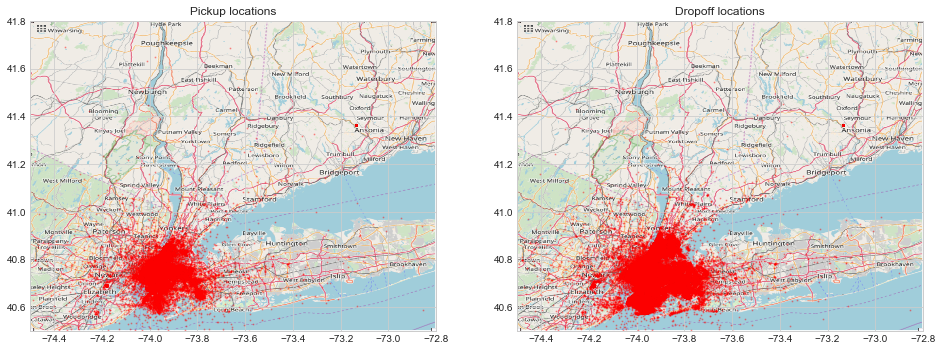

In [12]:
# plot training data on map
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

In [13]:
# plot training data on map zoomed in
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

It is evident from the plots that there are a lot of values in water, lets drop these

In [14]:
# read edited water mask image and superimpose on map image
nyc_mask = plt.imread('image/nyc_mask.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

In [15]:
# translate longitude/latitude coordinate into image xy coordinate
# see from the image above that y coordinate needs to be reversed

def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [16]:
# calculate for each lon,lat coordinate the xy coordinate in the mask map
# using lonlat_to_xy function

pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, nyc_mask.shape[1], nyc_mask.shape[0], BB) 

In [17]:
# calculate boolean index, that is, find the index for points which are on land

idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

In [18]:
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 1957918
New size: 1957530


In [19]:
# plot training data
plot_on_map(df_train, BB_zoom, nyc_map_zoom)

As we can see, there is some improvement. Points which are obviously on water have been removed.

##### Distance and time analysis

Some basic online research reveals that the price is dependent on:
- Distance of the trip
- Time spent on trip
- Some fare are flat, from/to airport etc
- Night time fares maybe higher, but we will have to confirm

In [20]:
# calculate distance using haversine formula
# https://stackoverflow.com/questions/27928/

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# add new column to dataframe with distance in miles
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('Distance (Miles)')
plt.title('Rides in miles')
df_train.distance_miles.describe()

count    1.957530e+06
mean     2.068194e+00
std      2.345983e+00
min      0.000000e+00
25%      7.789321e-01
50%      1.337189e+00
75%      2.431893e+00
max      7.132624e+01
Name: distance_miles, dtype: float64

Majority of the rides are short, falling below 3-4 miles

Lets check distance and fare amount by number of passengers

In [21]:
df_train.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()

distance_miles  fare_amount
passenger_count                             
0                      1.732107     8.813325
1                      2.040013    11.202837
2                      2.179313    11.800007
3                      2.100634    11.519105
4                      2.132165    11.721121
5                      2.072168    11.215987
6                      2.122414    12.169590
9                      8.106351   104.000000

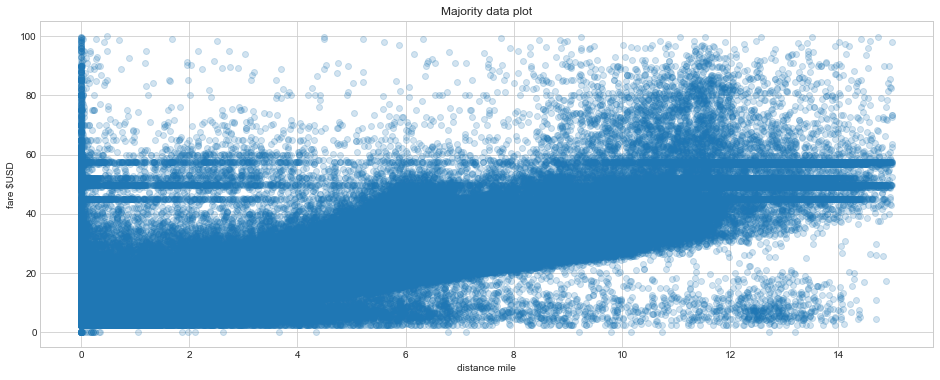

In [22]:
# plot fare against distance for trips less than 15 mile and fare less than 100 dollar
fig, axs = plt.subplots(1, 1, figsize=(16,6))
idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100)
axs.scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2)
axs.set_xlabel('distance mile')
axs.set_ylabel('fare $USD')
axs.set_title('Majority data plot');

There is a certain linear pattern, exception:
- there are some fixed fares in the 40-60 group, where the fare is consistent with no regard for distance. This maybe airports trip. It is worthwile to either remove this data from training altogether. Or implement flat fare along a radius around the airports.
- there are trips with zero distance, and non-zero fare, these maybe roundtrips, and do not impart any trainable information
- there is anomalous data, where distance is high, but the fare is low, these maybe discounted trips ?

In [23]:
# lets remove all trips with distance less than 0.1

# remove datapoints with distance <0.05 miles
idx = (df_train.distance_miles >= 0.1)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 1957530
New size: 1921796


In [24]:
# lets add some time related information

df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

# add fare per mile for each trip
df_train['fare_per_mile'] = df_train.fare_amount / df_train.distance_miles

Let's try to plot fare per mile, split by time measures, to try to find some evidence for peak time fares.

In [25]:
# display pivot table
df_train.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(18,8))
plt.ylabel('Fare $USD / mile');

Observations:
- There is some fare increase after 2012, maybe sometime during end of 2012 as the fares are somewhat higher compared to other years before it.
- The fare during night is lower, maybe due to less traffic offsetting any night time extra charges.
- Peak fare timings are during 0800 to 2200 hours.

In [26]:
# lets save the processed data (2 mil rows) in a new file

df_train.to_csv('processed.csv')